# 1 Author

**Student Name**:  Jingyu Huang
**Student ID**:  2021212797


# 2 Problem formulation
## 2.1 Proposed task:

Predicting gender from images is a fascinating yet challenging task with various applications, such as human-computer interaction, targeted advertising, and demographic analysis. In this problem, the goal is to design a model capable of accurately predicting the gender of individuals depicted in images.

## 2.2 interesting point
1. Similarity to Smile Classification: The task of gender classification shares similarities with smile classification. Leveraging the experience gained from smile classification models and pipelines can provide valuable insights. However, the key challenge lies in customizing the existing model and pipeline to effectively address the nuances of gender prediction.

2. Customization of Model and Pipeline: To enhance the performance of the model and tailor the pipeline to the gender prediction task, several aspects should be considered:

3. Feature Extraction: Reevaluate the features extracted by the model to identify gender-specific patterns. Adjusting the initial layers of the model architecture might be necessary to focus on relevant facial features indicative of gender.

4. Label Representation: Gender classification is a binary task, unlike smile classification. Modify the label representation and the output layer of the model accordingly. Ensure that the loss function aligns with the binary nature of the task.

5. Data Augmentation: While data augmentation has proven effective in various computer vision tasks, customizing augmentation techniques for gender prediction is essential. Explore transformations that preserve gender-related characteristics and contribute to a more robust model.

# 3 Machine Learning pipeline

The machine learning pipeline for gender prediction involves a series of steps designed to transform input images into meaningful predictions. The pipeline comprises face detection using dlib, image transformation, and a gender prediction model. Here is an overview of each stage:

image  ---> dlib  --->  transformation  --->  model  --->  output

## 3.1 Face Detection using dlib
- Input: (image_width, image_height, 3)

- Output: (cropped_image_width, cropped_image_height, 3)

- In this stage, the dlib library is employed for face detection in the input image. The output is a cropped image containing only the detected face, ensuring that subsequent processing focuses on the relevant facial features for gender prediction.

## 3.2 Image Transformation
- Input: (cropped_image_width, cropped_image_height, 3)

- Output: (3, 224, 224)

- The cropped face image undergoes a series of transformations to standardize its dimensions and prepare it for input into the gender prediction model. The transformations typically include resizing, cropping, and normalization. The output is a transformed image with consistent dimensions suitable for model input.

## 3.3 Gender Prediction Model
- Input: (3, 224, 224)

- Output: (1, 2)

- The transformed image is fed into the gender prediction model. The model, customized for binary gender classification, outputs a probability distribution indicating the likelihood of the individual being male or female. The two-dimensional output represents the binary classification result.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import torch.nn.functional as F
import torchvision
import cv2 as cv
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
from PIL import Image
import math
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix



# 4 Transformation stage

The transformation stage is a critical component of the machine learning pipeline for gender prediction. It involves processing the input image, obtained after face detection using dlib, to ensure it is well-suited for the subsequent gender prediction model. The series of steps in the transformation stage are as follows:

## 4.1Resize to (256, 256):

- Input: (cropped_image_width, cropped_image_height, 3)
- Output: (256, 256, 3)
- The cropped image is resized to dimensions (256, 256) to provide a consistent input size to the subsequent augmentation and model stages.

## 4.2Random Crop to (244, 244):

- Input: (256, 256, 3)
- Output: (244, 244, 3)
- Random cropping is applied to the image, ensuring that the model receives diverse input during training. This step focuses on the facial region, providing variability in the training data.

## 4.3Random Horizontal Flip:

- Input: (244, 244, 3)
- Output: (244, 244, 3)
- To further augment the dataset, a random horizontal flip is applied. This step introduces additional variability by presenting mirrored versions of the images.

## 4.4Tensorization:

- Input: (244, 244, 3)
- Output: (3, 244, 244)
- The image is converted into a tensor to facilitate processing by the gender prediction model. This step results in a change in dimensions from (244, 244, 3) to (3, 244, 244).

## 4.5Normalization:

- Input: (3, 244, 244)
- Output: (3, 244, 244)
- Normalization is applied to the tensorized image, ensuring that pixel values are scaled appropriately. This step aids in stabilizing the training process and enhancing the model's ability to generalize.

In [3]:
image_size = 224
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]


data_transforms = {
            'train': transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(244),
                transforms.RandomCrop([image_size,image_size]),
                transforms.ToTensor(),
                transforms.Normalize(normalize_mean, normalize_std)
            ]),
            'val': transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(256),
                transforms.CenterCrop(image_size),
                transforms.ToTensor(),
                transforms.Normalize(normalize_mean, normalize_std)
            ])
            }

data_increase = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(244),
    transforms.RandomCrop([image_size,image_size]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(normalize_mean, normalize_std)
])



## 5 Modelling

In the modeling stage, a ResNet (Residual Network) architecture is adopted for smile detection. The choice of ResNet is motivated by its success in handling complex visual tasks, especially in mitigating the vanishing gradient problem through the use of residual connections. The ResNet model outputs a two-dimensional tensor representing smile probabilities.

Model Architecture
The ResNet model is structured with five layers, each consisting of different components aimed at effective feature extraction and learning.

1. First Layer
    Convolutional Layer:

        Kernel Size: 7x7

        Stride: 2

        Objective: Enlarges the model's receptive field for comprehensive feature extraction while downsampling pixel size through a 2x2 stride.

    Max Pooling Layer:

        Pool Size: 3x3

        Stride: 2

        Objective: Further downsamples the pixel size, enhancing feature abstraction.
2. Second Layer

    Block Structure:

    Multiple blocks with convolutional layers, adopting a kernel size of 3x3 and a stride of 1.

    Bottleneck Architecture: Introduces a bottleneck structure between blocks, reducing the model's parameter count and enhancing efficiency.

3. Third to Fifth Layers

    Block Structure:

    Similar to the second layer but with a stride of 2 in the convolutional layers, achieving further downsampling.

4. Final Layers

    Average Pooling Layer:

        Pool Size: Global Average Pooling

        Objective: Reduces the pixel size to 1x1, summarizing feature maps.

    Fully Connected Layer:

        Output Size: 2 (for binary classification)

        Objective: Produces a two-dimensional vector representing smile probabilities for each class.


In [4]:
class  BN_Conv2d(nn.Module):
    def __init__(self, in_channels: object, out_channels: object, kernel_size: object, stride: object, padding: object,
                 dilation=1, groups=1, bias=False, activation=True) -> object:
        super(BN_Conv2d, self).__init__()
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride,
                            padding=padding, dilation=dilation, groups=groups, bias=bias),
                  nn.BatchNorm2d(out_channels)]
        if activation:
            layers.append(nn.ReLU(inplace=True))
        self.seq = nn.Sequential(*layers)

    def forward(self, x):
        return self.seq(x)
    
class BasicBlock(nn.Module):
    message = "basic"

    def __init__(self, in_channels, out_channels, strides, is_se=False):
        super(BasicBlock, self).__init__()
        self.is_se = is_se
        self.conv1 = BN_Conv2d(in_channels, in_channels, 1, stride=strides, padding=0, bias=False)  # same padding
        self.conv2 = BN_Conv2d(in_channels, out_channels, 3, stride=1, padding=1, bias=False)
        self.conv3 = BN_Conv2d(out_channels, out_channels, 1, stride=1, padding=0, bias=False, activation=False)


        # fit input with residual output
        self.short_cut = nn.Sequential()
        if strides != 1:
            self.short_cut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=strides, padding=0, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out + self.short_cut(x)
        return F.relu(out)
    
class ResNet(nn.Module):
    """
    building ResNet_34
    """

    def __init__(self, block: object, groups: object, num_classes) -> object:
        super(ResNet, self).__init__()
        self.channels = 64  # out channels from the first convolutional layer
        self.block = block

        self.conv1 = nn.Conv2d(3, self.channels, 7, stride=2, padding=3, bias=False)
        self.bn = nn.BatchNorm2d(self.channels)
        self.pool1 = nn.MaxPool2d(3, 2, 1)
        self.conv2_x = self._make_conv_x(channels=64, blocks=groups[0], strides=1, index=2)
        self.conv3_x = self._make_conv_x(channels=128, blocks=groups[1], strides=2, index=3)
        self.conv4_x = self._make_conv_x(channels=256, blocks=groups[2], strides=2, index=4)
        self.conv5_x = self._make_conv_x(channels=512, blocks=groups[3], strides=2, index=5)
        self.pool2 = nn.AvgPool2d(7)
        patches = 512 if self.block.message == "basic" else 512 * 4
        self.fc = nn.Linear(patches, num_classes)  # for 224 * 224 input size

    def _make_conv_x(self, channels, blocks, strides, index):
        """
        making convolutional group
        :param channels: output channels of the conv-group
        :param blocks: number of blocks in the conv-group
        :param strides: strides
        :return: conv-group
        """
        list_strides = [strides] + [1] * (blocks - 1)  # In conv_x groups, the first strides is 2, the others are ones.
        conv_x = nn.Sequential()
        for i in range(len(list_strides)):
            layer_name = str("block_%d_%d" % (index, i))  # when use add_module, the name should be difference.
            conv_x.add_module(layer_name, self.block(self.channels, channels, list_strides[i]))
            self.channels = channels if self.block.message == "basic" else channels * 4
        return conv_x

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(self.bn(out))
        out = self.pool1(out)
        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.conv5_x(out)
        out = self.pool2(out)
        out = out.view(out.size(0), -1)
        out = F.softmax(self.fc(out))
        return out

# 6 Methodology

The methodology outlines the approach taken for training, validation, and performance assessment of the ResNet-based smile detection model.

## 6.1 Setting Hyperparameters
Epochs (epochs_num): The training process is set to run for 100 epochs. This choice is based on empirical testing, where it is observed that the model typically converges within the range of 50 to 70 epochs, and further training may not significantly improve performance.

Learning Rate (learning_rate): A learning rate of 0.001 is selected. This value is slightly higher as the optimizer employs a decay strategy later in the training process. The higher initial learning rate allows the model to explore a larger portion of the parameter space in the early stages of training.

## 6.2 Learning Rate Decay
Decay Mechanism: The learning rate is subjected to decay using a milestone-based strategy. Specific milestones, indicated by epochs, are defined to trigger a reduction in the learning rate. The chosen milestones are [30, 40, 50, 60, 70].
## 6.3 Early Stopping
Patience (patience): Early stopping is implemented with a patience value of 8. This means that if the model fails to achieve a lower loss value over eight consecutive epochs, training is halted, assuming the model has effectively converged.
## 6.4 Training and Validation
Loss Function: The model is trained using the cross-entropy loss function, suitable for binary classification tasks like smile detection.

Optimizer: The Adam optimizer is utilized for its adaptive learning rate properties.

Model Training: The model is trained on the training dataset using the specified hyperparameters. During each epoch, the model parameters are updated to minimize the training loss.

Model Validation: The model's performance is assessed on a separate validation dataset to monitor its ability to generalize to unseen data.

## 6.5 Performance Assessment
Metrics: The primary metric for performance assessment is accuracy, indicating the proportion of correctly classified samples over the total number of samples. Additional metrics such as precision, recall, and F1 score may be considered for a more detailed evaluation.

Confusion Matrix: A confusion matrix may be generated to provide insights into the model's classification performance, showing true positives, true negatives, false positives, and false negatives.

Visualization: Plots and visualizations, such as accuracy and loss curves, may be employed to analyze the model's learning trends over epochs.

Accurency: the ratio of the number of the right prediction to the total number of the samples.  

## 6.6 Early Stop Criterion
If the model fails to achieve a lower validation loss over a specified patience period, early stopping is triggered, preventing overfitting and expediting the training process.
The outlined methodology aims to strike a balance between achieving optimal model performance, avoiding overfitting, and minimizing training time through the use of carefully selected hyperparameters and training strategies.








In [5]:
def plot_confusion_matrix(cm, labels_name, title):
    plt.cla()
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    
    plt.imshow(cm, interpolation='nearest')    
    plt.title(title)    
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    
    plt.yticks(num_local, labels_name)    
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')

In [16]:
sample_num=1000
num_epochs = 100
train_batch_size = 16
learning_rate= 0.001
milestones = [30, 40, 50, 60, 70]
gamma = 0.8
best_loss = 1
patience = 8

model = ResNet(BasicBlock,[2,2,2,2],2)
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
torch.optim.lr_scheduler.MultiStepLR(optimizer,
                    milestones=milestones, gamma=gamma)

def model_train(model,criterion,optimizer,train_loader,val_loader,best_loss):
    train_epochs_loss = []
    val_epochs_loss = []
    train_epochs_acc = []
    val_epochs_acc = []

    for epoch in range(num_epochs):
        model.train()
        train_epoch_loss = []
        acc, nums = 0, 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.cuda()
            outputs = model(inputs)
            labels = labels.cuda()
            labels = labels.long()
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_epoch_loss.append(loss.item())
            # print(labels)
            # print(outputs)
            # print(outputs.max(axis=1)[1])
            acc += sum(outputs.max(axis=1)[1] == labels)
            nums += labels.size()[0]
            # print("train acc = {:.3}%".format(100 * sum(outputs.max(axis=1)[1] == labels) / labels.size()[0]))
            if (i + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        train_epochs_loss.append(np.average(train_epoch_loss))
        train_epochs_acc.append(100 * acc / nums)
        with torch.no_grad():
            model.eval()
            acc, nums = 0, 0
            val_epoch_loss = []
            for i, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.cuda()
                labels = labels.cuda()
                outputs = model(inputs)
                labels = labels.long()
                loss = criterion(outputs, labels)
                val_epoch_loss.append(loss.item())
                acc += sum(outputs.max(axis=1)[1] == labels)
                # print(labels)
                # print(outputs)
                # print(outputs.max(axis=1)[1])
                nums += labels.size()[0]
            val_epochs_loss.append(np.average(val_epoch_loss))
            val_epochs_acc.append(100 * acc / nums)
            val_loss = np.average(val_epoch_loss)
            torch.save(model.state_dict(), "checkpoints/gender_detect_last.pth")
            print("epoch = {}, valid acc = {:.2f}%, loss ={}".format(epoch + 1, 100 * acc / nums,
                                                                        np.average(val_epoch_loss)))
            if val_loss<best_loss:
                counter = 0
                best_loss = val_loss
                torch.save(model.state_dict(), "checkpoints/gender_detect_best.pth")
            else:
                counter += 1
            if counter >= patience:
                print("Earlystop")
                break

    print("Training complete!")

    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    train=[]
    val=[]
    for i in range(len(train_epochs_acc)):
        train.append(train_epochs_acc[i].cpu())
    for i in range(len(val_epochs_acc)):
        val.append(val_epochs_acc[i].cpu())

    plt.plot(train[:])
    plt.plot(val[:])
    plt.title("train_acc and val_acc")
    plt.subplot(1,2,2)
    plt.plot(train_epochs_loss, '-o', label="train_loss")
    plt.plot(val_epochs_loss, '-o', label="valid_loss")
    plt.title("epochs_loss")
    plt.legend()
    plt.show()

   

def model_test(model,criterion,test_loader):
     # test the model
    acc, nums = 0, 0
    pre=[]
    true=[]
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        labels = labels.long()
        loss = criterion(outputs, labels)
        #     print(labels)

        #     print(outputs.max(axis=1)[1])
        acc += sum(outputs.max(axis=1)[1] == labels)
        pre.append(outputs.max(axis=1)[1].item())
        true.append(labels.item())
        nums += labels.size()[0]
    print("test acc = {:.3}%".format(100 * acc / nums))
    a =  confusion_matrix(pre, true,labels=range(0,2))
    return a



# 7 Dataset

The dataset creation involves utilizing the torch.utils.data.Dataset method to organize and structure the data for training and evaluation. The dataset consists of image addresses (x_data) and corresponding labels (y_data). The transformation operations defined earlier are applied to preprocess the images before they are fed into the gender prediction model.

## 7.1 Dataset Structure
The dataset is organized in the following manner:

- x_data: Image Addresses
- y_data: Four-dimensional Label (Batch Size x Channels x Height x Width)
## 7.2 DataLoader Output
The DataLoader output reflects the transformed and preprocessed data ready to be consumed by the gender prediction model. Each batch in the DataLoader output has the following dimensions:

- x_data: (Batch Size, 3, 224, 224) - Tensorized and Normalized Image
- y_data: (Batch Size, 1, 1) - Four-dimensional Label

## 7.3 Data Loading Process
- Image Loading:

    Using OpenCV (cv2), images are loaded into the dataset from the specified addresses (x_data).
- Transformation:

    The transformation operations defined earlier (cropping, resizing, augmentation, tensorization, and normalization) are applied to preprocess each image.
- Label Processing:

    The label associated with each image is used as the four-dimensional label (y_data). The first dimension of this label represents the gender information.

In [7]:

pictures_path=['crop_pad_img/file{}.jpg'.format(str(i).zfill(4)) for i in range(1,4001)]
label_data = np.genfromtxt("genki4k/newlabel/labels.txt")  

class genderDataset(Dataset):
    def __init__(self,x_data,y_data,transforms,if_train,data_increase):
        self.x_data=x_data
        self.transforms = transforms
        self.y_data=torch.from_numpy(y_data[:,1])
        self.len=len(x_data)
        self.if_train = if_train
        self.data_increase = data_increase
        if self.if_train ==True:
            self.true_len = self.len*2
        if self.if_train ==False:
            self.true_len = self.len
        self.data_increase = data_increase
    def __getitem__(self,index):
        if(index>=self.len):
            img = cv.imread(self.x_data[index-self.len])
            img = self.data_increase(img)
            label = self.y_data[index-self.len]
        
        
        if (index<self.len):
            img = cv.imread(self.x_data[index])
            img = self.transforms(img)
            label = self.y_data[index]

        return img,label
    def __len__(self):
        return self.true_len
    

train_dataset=genderDataset(x_data=pictures_path[0:800],y_data=label_data[0:800] , transforms=data_transforms['train'],if_train=True,data_increase=data_increase)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=train_batch_size,
                          shuffle=True)
val_dataset=genderDataset(x_data=pictures_path[800:900],y_data=label_data[800:900],transforms=data_transforms["val"],if_train=False,data_increase=data_increase)
val_loader = DataLoader(dataset=val_dataset,
                          batch_size=10,
                          shuffle=True)
test_dataset=genderDataset(x_data=pictures_path[900:1000],y_data=label_data[900:1000],transforms=data_transforms['val'],if_train=False,data_increase=data_increase)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=1,
                          shuffle=True)

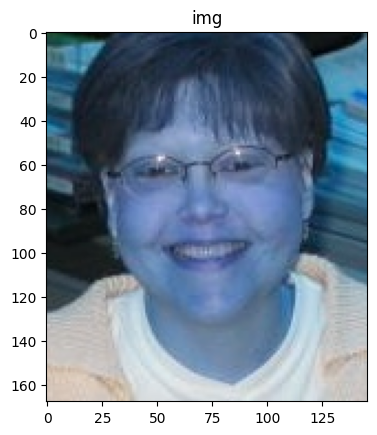

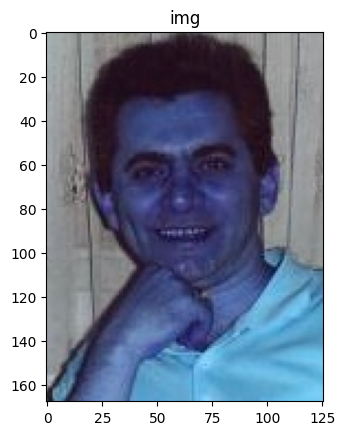

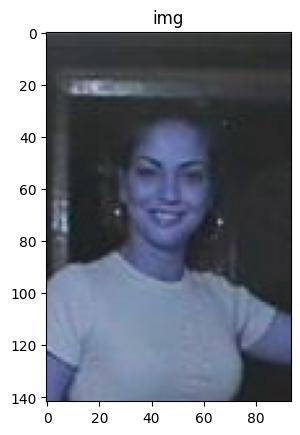

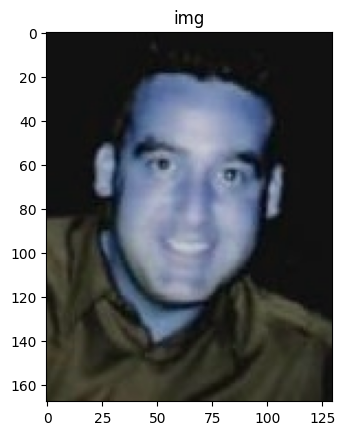

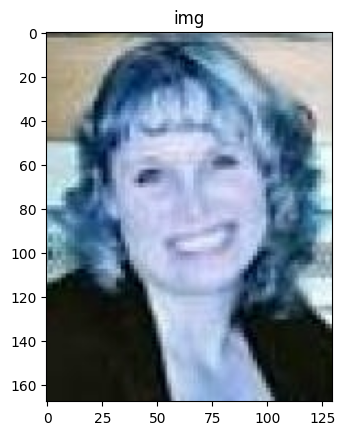

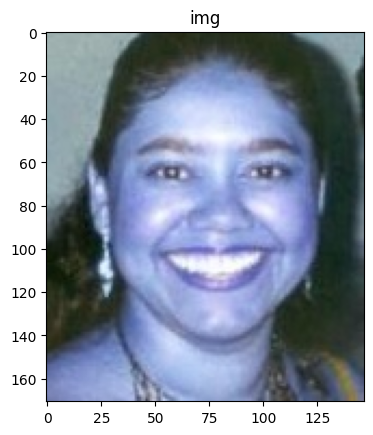

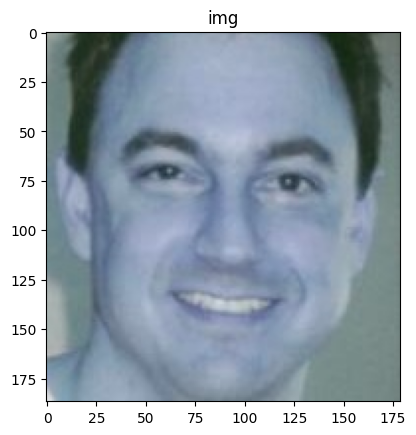

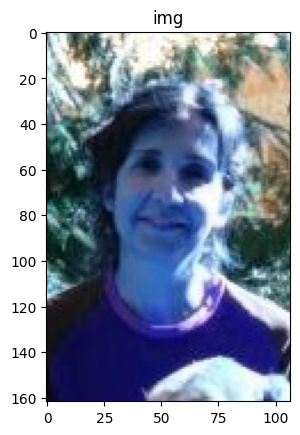

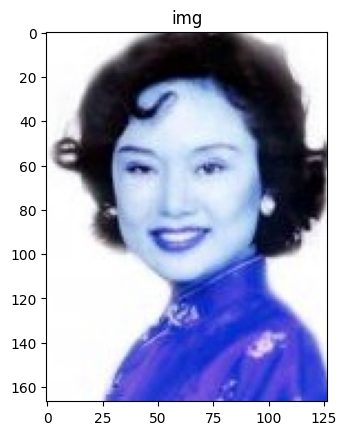

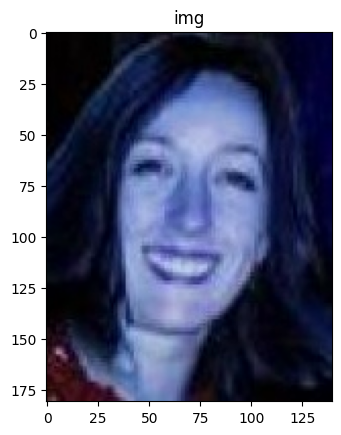

In [8]:
for i in range(0,10):
    img = cv.imread(pictures_path[i])
    plt.imshow(img)
    plt.title('img')
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


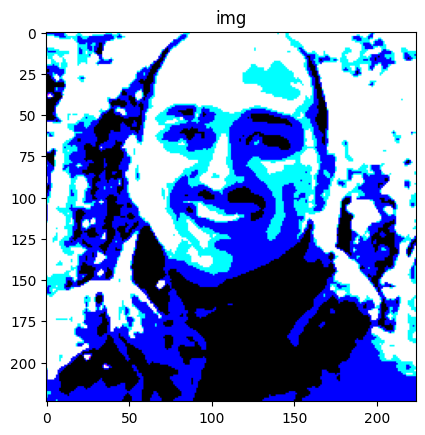

torch.Size([224, 224, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


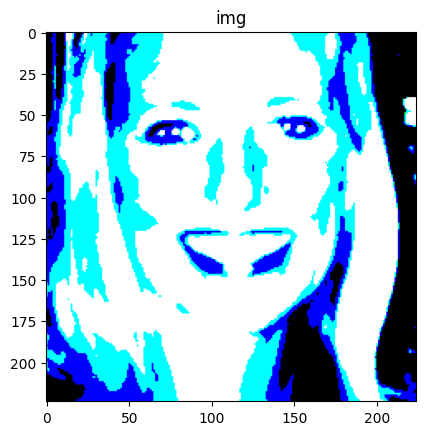

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


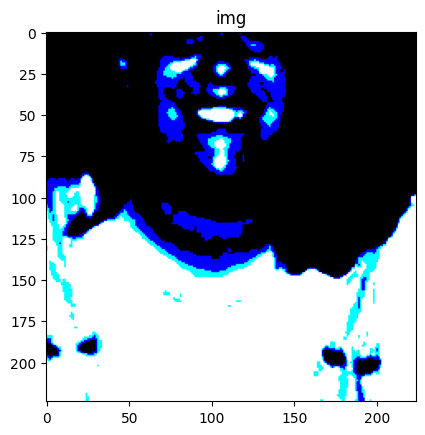

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


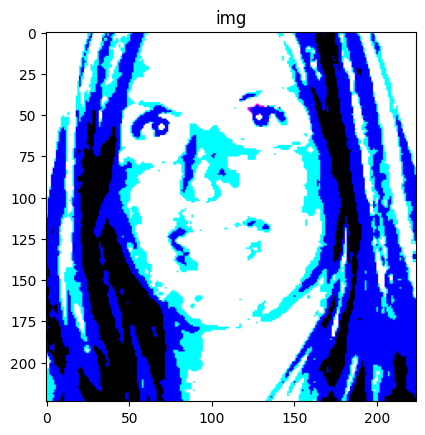

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


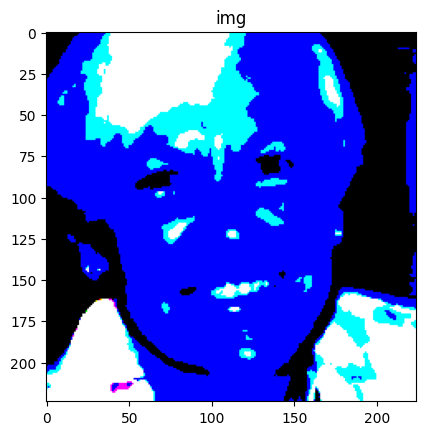

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


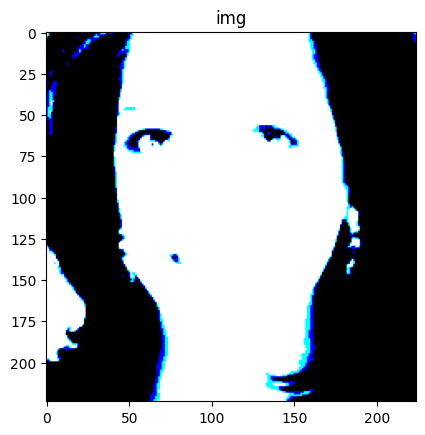

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


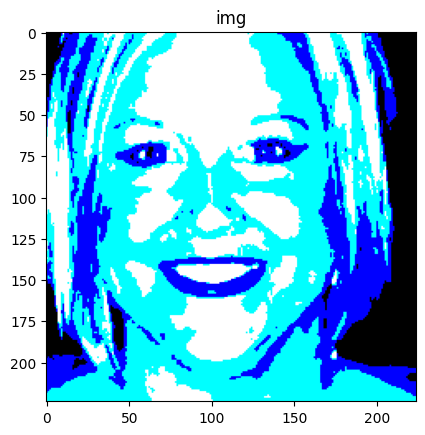

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


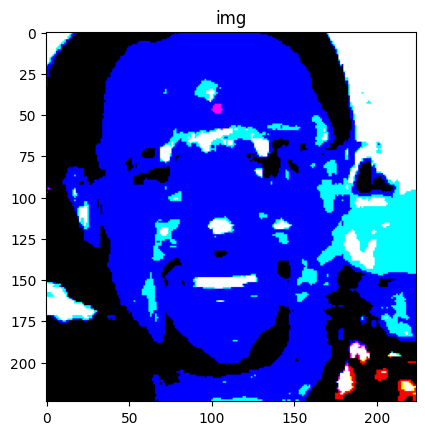

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


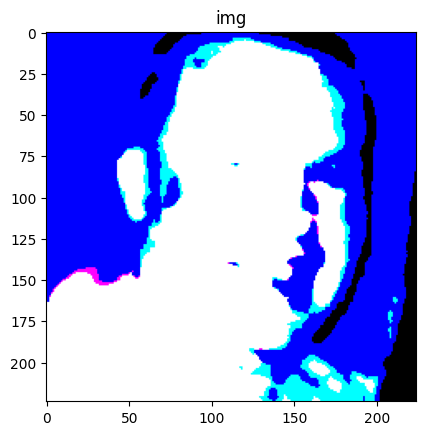

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


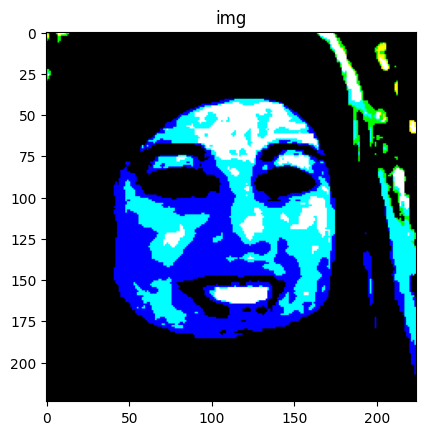

In [9]:
for i, (img,label) in enumerate(train_loader):
    for j in range (0,10):
        img_t = img[j]
        # img_t=img_t.view(224,224,3)
        # img_t =img_t.numpy()

        ndarr = img_t.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0)
        print(ndarr.shape)
        plt.imshow(ndarr)
        plt.title('img')
        plt.show()
    break

# 8 Results

After training the model for 36 epochs, it achieved a satisfactory level of fitting, yielding a 73% accuracy on the test set. The evaluation results, including the confusion matrix, shed light on the model's performance.

## 8.1 Training Progress
Loss Graph:

    The loss graph reveals significant fluctuations in the model's loss values. This behavior may be attributed to the limited size of the dataset and the inadequacy of the data augmentation strategy.

## 8.2 Evaluation Metrics
Accuracy Trends:

    The training accuracy gradually increased, reaching around 82.5%. However, the validation accuracy exhibited notable fluctuations. While it peaked at 80%, it dropped to approximately 75% in the last epoch.

Confusion Matrix:

    Analyzing the confusion matrix indicates that the model performs better in predicting samples with label 1, achieving an accuracy of 80%. However, its accuracy in predicting label 0 is comparatively lower, around 65%.

## 8.3 Discussion
The results suggest potential areas for improvement, especially concerning the model's generalization on unseen data. The fluctuation in validation accuracy and the discrepancy in predicting different labels point towards challenges that could be addressed through further fine-tuning of the model, revisiting data augmentation strategies, or exploring alternative architectures.

The obtained insights provide valuable information for refining the model and optimizing its performance, paving the way for future iterations and improvements in gender prediction accuracy.

In [1]:
model_train(model,criterion,optimizer,train_loader,val_loader,best_loss)
matrix = model_test(model,criterion,test_loader)


NameError: name 'model_train' is not defined

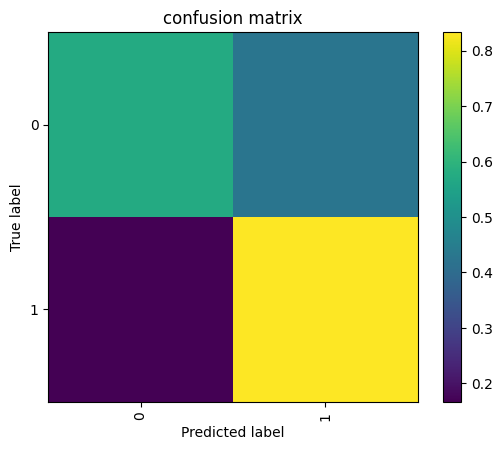

In [ ]:
plot_confusion_matrix(matrix,[0,1],"confusion matrix")

# 9 Conclusions

In conclusion, this project aimed to design a model for predicting the gender of individuals in images. Leveraging concepts from previous work on facial expression classification, the machine learning pipeline was customized for this specific task. Several interesting points were considered during the formulation and implementation of the model.

## 9.1 Model Customization
Task Similarity with Facial Expression Classification:

Drawing inspiration from the similarity between gender classification and facial expression tasks, the existing model and pipeline were adapted. This adaptation facilitated a quicker start, but the key challenge was to ensure effective customization without compromising the model's performance.
Customization Time vs. Model Performance:

Balancing the time spent on customization against the potential gains in model performance emerged as a crucial consideration. Striking the right balance was vital to ensuring that the model addressed the nuances of gender prediction without excessive complexity.
## 9.2 Data Augmentation
Expanding Dataset Through Data Augmentation:

Given the human-labeled nature of the dataset, the exploration of data augmentation techniques was considered. This approach aimed to augment the dataset by applying transformations to the original images, potentially enhancing the model's ability to generalize.
Challenges in Data Augmentation:

However, the implementation of data augmentation faced challenges. Fluctuations in the loss graph indicated that the augmentation strategy might not have been sufficiently effective or that alternative approaches could be explored.
## 9.3 Model Performance and Challenges
Training Progress:

The model achieved a fitting level after 36 epochs, attaining a 73% accuracy. Nevertheless, the fluctuating loss values raised questions about the adequacy of the dataset and the efficacy of data augmentation.
Accuracy Trends and Confusion Matrix:

While training accuracy showed improvement, the validation accuracy exhibited fluctuations. The confusion matrix highlighted variations in prediction accuracy for different labels, indicating areas for refinement.